In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (Dense, BatchNormalization, Activation,
                                     Dropout, Conv1D, GlobalAveragePooling1D, Input)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
seed = 1234
np.random.seed(seed)

# Cargar datos

In [ ]:
#lee datos de entrada csv
#data_original = pd.read_csv('data_ext.csv')
#data_peru = pd.read_csv('data_peru.csv')

In [ ]:
data_original = pd.read_csv('rna_seq_corrected2.csv')
data_peru = pd.read_csv('microarray_corrected2.csv')

In [ ]:
data_original

,Unnamed: 0,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,...,LARRPM,C3orf36,ZCCHC14-DT,LINC01949,C8orf44,ELOA3BP,NPBWR1,CDR1,ACTL10,labels
0,X0,-0.462045,0.083561,-0.086972,-0.049877,0.038498,0.225652,-0.112927,-0.130873,0.223246,...,0.123967,-0.144945,-0.014248,-0.033451,0.039169,-0.090088,0.290131,-0.020728,0.000009,cancer
1,X1,-0.045234,0.041042,-0.004232,-0.132393,-0.060242,-0.032321,-0.209566,0.061246,0.051514,...,-0.022800,-0.207488,0.028027,-0.026371,-0.271356,0.017593,0.090757,-0.024039,-0.000074,cancer
2,X2,0.299007,-0.014664,0.218664,0.028422,0.034654,-0.057977,-0.151614,-0.055614,0.012914,...,-0.024602,0.053704,-0.078955,0.035379,0.196569,-0.010428,0.165409,-0.073618,0.000085,cancer
3,X3,0.255464,-0.059593,-0.079080,-0.247562,-0.165905,0.015496,0.093609,0.142359,0.140536,...,0.163110,0.202340,0.188984,0.010634,0.038042,-0.097157,0.089660,-0.028778,0.000028,cancer
4,X4,-0.105428,0.054279,-0.233043,-0.208406,-0.044679,0.149433,0.217659,-0.182044,0.194777,...,0.202967,0.087751,0.358477,-0.169925,-0.259865,0.020489,0.116502,0.011058,0.000031,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,X95,-0.106755,-0.076390,0.019498,0.059895,0.005306,0.002093,-0.190453,0.098184,-0.079503,...,0.056216,0.056745,-0.081697,0.038087,-0.098876,-0.025284,0.110526,-0.036154,0.000057,healthy
96,X96,0.096247,0.159679,-0.034358,-0.061951,-0.044873,0.103354,0.114864,0.036630,-0.001218,...,0.181990,0.050028,-0.047105,-0.020306,0.023888,0.032047,-0.403793,-0.008930,-0.000036,healthy
97,X97,-0.227377,0.210300,0.016070,-0.012767,0.092230,0.118250,0.004921,-0.030761,0.155772,...,-0.025249,0.023507,0.232790,0.055300,0.103684,-0.018980,0.077472,-0.026488,0.000016,healthy
98,X98,-0.011385,0.028017,0.073579,-0.077299,-0.010724,0.051077,-0.028448,-0.039486,0.196411,...,0.078421,0.013359,-0.028330,-0.042092,-0.169553,0.003680,-0.067709,-0.018494,0.000137,healthy


In [ ]:
data_original.columns

Index(['Unnamed: 0', 'TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH',
       'FUCA2', 'GCLC',
       ...
       'LARRPM', 'C3orf36', 'ZCCHC14-DT', 'LINC01949', 'C8orf44', 'ELOA3BP',
       'NPBWR1', 'CDR1', 'ACTL10', 'labels'],
      dtype='object', length=23010)

In [ ]:
#borra la primera columna
data_original = data_original.drop(data_original.columns[0], axis=1)

In [ ]:
data_original

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,LARRPM,C3orf36,ZCCHC14-DT,LINC01949,C8orf44,ELOA3BP,NPBWR1,CDR1,ACTL10,labels
0,-0.462045,0.083561,-0.086972,-0.049877,0.038498,0.225652,-0.112927,-0.130873,0.223246,-0.214854,...,0.123967,-0.144945,-0.014248,-0.033451,0.039169,-0.090088,0.290131,-0.020728,0.000009,cancer
1,-0.045234,0.041042,-0.004232,-0.132393,-0.060242,-0.032321,-0.209566,0.061246,0.051514,-0.010835,...,-0.022800,-0.207488,0.028027,-0.026371,-0.271356,0.017593,0.090757,-0.024039,-0.000074,cancer
2,0.299007,-0.014664,0.218664,0.028422,0.034654,-0.057977,-0.151614,-0.055614,0.012914,-0.045669,...,-0.024602,0.053704,-0.078955,0.035379,0.196569,-0.010428,0.165409,-0.073618,0.000085,cancer
3,0.255464,-0.059593,-0.079080,-0.247562,-0.165905,0.015496,0.093609,0.142359,0.140536,0.076378,...,0.163110,0.202340,0.188984,0.010634,0.038042,-0.097157,0.089660,-0.028778,0.000028,cancer
4,-0.105428,0.054279,-0.233043,-0.208406,-0.044679,0.149433,0.217659,-0.182044,0.194777,-0.067265,...,0.202967,0.087751,0.358477,-0.169925,-0.259865,0.020489,0.116502,0.011058,0.000031,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.106755,-0.076390,0.019498,0.059895,0.005306,0.002093,-0.190453,0.098184,-0.079503,0.060578,...,0.056216,0.056745,-0.081697,0.038087,-0.098876,-0.025284,0.110526,-0.036154,0.000057,healthy
96,0.096247,0.159679,-0.034358,-0.061951,-0.044873,0.103354,0.114864,0.036630,-0.001218,-0.184529,...,0.181990,0.050028,-0.047105,-0.020306,0.023888,0.032047,-0.403793,-0.008930,-0.000036,healthy
97,-0.227377,0.210300,0.016070,-0.012767,0.092230,0.118250,0.004921,-0.030761,0.155772,0.135621,...,-0.025249,0.023507,0.232790,0.055300,0.103684,-0.018980,0.077472,-0.026488,0.000016,healthy
98,-0.011385,0.028017,0.073579,-0.077299,-0.010724,0.051077,-0.028448,-0.039486,0.196411,-0.040456,...,0.078421,0.013359,-0.028330,-0.042092,-0.169553,0.003680,-0.067709,-0.018494,0.000137,healthy


In [ ]:
print(data_original.labels.value_counts())

labels
cancer     50
healthy    50
Name: count, dtype: int64


In [ ]:
data_peru = data_peru.drop(data_peru.columns[0], axis=1)

In [ ]:
data_peru

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,LARRPM,C3orf36,ZCCHC14-DT,LINC01949,C8orf44,ELOA3BP,NPBWR1,CDR1,ACTL10,labels
0,0.347722,0.009227,0.001049,-0.121657,-0.036494,0.268795,0.095465,-0.239877,0.015832,-0.136638,...,0.127118,-0.106181,-0.073948,0.067466,-0.105408,-0.019306,0.145968,-0.088505,0.000033,cancer
1,0.079986,-0.018669,0.112127,-0.128869,0.055986,-0.108337,0.265995,0.379369,0.133628,0.215664,...,-0.132127,0.008536,0.038956,-0.034629,0.138869,-0.008116,-0.197206,-0.174964,0.000037,cancer
2,-0.105958,-0.027307,0.138527,0.050304,0.164187,-0.200202,0.115081,-0.101162,-0.094127,0.281875,...,-0.042487,-0.032222,0.121635,0.031210,0.122394,0.250967,0.091043,0.072379,0.000054,cancer
3,-0.386897,0.003913,0.018609,-0.064914,-0.003853,0.041489,0.008954,0.322623,-0.109609,-0.098171,...,-0.114890,-0.032833,0.316335,0.055042,-0.163901,-0.073420,-0.181865,0.043410,0.000027,cancer
4,-0.228978,-0.027778,-0.063850,-0.045214,-0.090222,0.114661,0.064256,-0.009803,0.075537,-0.037328,...,0.052828,-0.090610,-0.180631,0.017844,-0.068832,0.011175,0.218893,-0.083839,-0.000005,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.052218,-0.061681,-0.082672,0.123213,0.116835,0.068876,-0.014470,0.110310,-0.052817,-0.027412,...,-0.168661,0.063140,-0.021858,-0.042584,-0.026179,0.034531,0.341602,0.048321,-0.000175,healthy
65,0.013919,0.636253,-0.048321,-0.067494,0.234535,0.060093,-0.125327,0.138941,0.092495,0.003236,...,-0.091949,0.140093,-0.121796,-0.006222,0.129409,0.003320,-0.032207,-0.005985,-0.000196,healthy
66,0.012281,0.114601,0.024910,-0.008703,-0.168168,0.026059,-0.023973,0.022916,0.144669,0.020540,...,0.006083,-0.141103,-0.360824,-0.007860,-0.000076,-0.008522,0.044246,0.024955,0.004120,healthy
67,0.235078,-0.091735,-0.225165,-0.126232,-0.210174,-0.022305,-0.027714,0.075614,-0.040455,0.016113,...,-0.006377,-0.058623,-0.285260,0.006732,-0.058814,-0.004511,-0.122754,0.038720,-0.000195,healthy


# Parametros

In [ ]:
hyperparameter_grid = {
    'filters': [64],
    'kernel_size': [5, 10],
    'dense_units': [64, 128],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16],
    'n_iter': [2000]  # Early stopping con máximo 2000 épocas
}

In [ ]:
# Generar combinaciones de hiperparámetros
param_keys = list(hyperparameter_grid.keys())
param_values = list(hyperparameter_grid.values())
param_combinations = [dict(zip(param_keys, values)) for values in itertools.product(*param_values)]

# Funciones

In [ ]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = tf.keras.layers.add([x, shortcut])
    x = Activation('relu')(x)

    return x

In [ ]:
def getGeneXNetModel(input_shape, params):
    inputs = Input(shape=input_shape)

    # Primera capa de convolución
    x = Conv1D(params['filters'], kernel_size=params['kernel_size'], padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Bloques residuales
    for _ in range(3):  # Puedes ajustar el número de bloques residuales
        x = residual_block(x, params['filters'], kernel_size=params['kernel_size'])

    # Pooling global para reducir dimensiones
    x = GlobalAveragePooling1D()(x)

    # Capa densa final
    x = Dense(params['dense_units'], activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model

In [ ]:
def evaluate_model(model, X_test, y_test):
    val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
    return val_acc

# Función para obtener predicciones
def get_predictions(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    predictions_class = (predictions >= 0.5).astype(int)
    return predictions_class, y_test

# Función para guardar resultados
def save_results(results, predictions_per_fold, filename):
    with open(filename, 'wb') as f:
        pickle.dump({'results': results, 'predictions_per_fold': predictions_per_fold}, f)
    print(f"Resultados guardados en {filename}")

In [ ]:
def load_results_from_drive(filename):
    filepath = os.path.join(results_dir, filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        print(f"Resultados cargados desde {filepath}")
        return data['results'], data['predictions_per_fold']
    else:
        print(f"No se encontró el archivo {filepath}. Iniciando nuevos resultados.")
        return [], []

# Entrenamiento

In [ ]:
y = np.where(data_original['labels'].values == 'cancer', 1, 0)
X = data_original.drop('labels', axis=1).values

In [ ]:
import json
# Cargar las divisiones guardadas desde el archivo
with open('splits.json', 'r') as f:
    splits = json.load(f)

train_indices_list = splits['train']
test_indices_list = splits['test']
n_splits = len(train_indices_list)

In [ ]:
results = []
predictions_per_fold = []

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoint_root_dir = '/content/drive/My Drive/GeneXNet/checkpoints/'  # Directorio para guardar los checkpoints

In [ ]:
results_dir = '/content/drive/My Drive/GeneXNet/results'
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# Cargar resultados previos si existen
results, predictions_per_fold = load_results_from_drive('checkpoint_results.pkl')

Resultados cargados desde /content/drive/My Drive/GeneXNet/results/checkpoint_results.pkl


# Entrenando todo el conjunto de datos con los mejores hiperparámetros

In [ ]:
# Al finalizar, obtener los mejores hiperparámetros basados en la precisión promedio
best_result = max(results, key=lambda x: x['accuracy'])
print(f"Mejores hiperparámetros: {best_result['params']}, Precisión: {best_result['accuracy']:.4f}")

Mejores hiperparámetros: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'learning_rate': 0.0001, 'batch_size': 16, 'n_iter': 2000}, Precisión: 0.6300


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn import linear_model
import tensorflow as tf

# Asumiendo que los datos completos están en X y y
X_train_full = X  # Asegúrate de que X contenga todo el conjunto de datos
y_train_full = y  # Asegúrate de que y contenga todas las etiquetas

# Mejores hiperparámetros encontrados
best_params = {
    'filters': 64,
    'kernel_size': 5,
    'dense_units': 128,
    'learning_rate': 0.0001,
    'batch_size': 16,
    'n_iter': 2000
}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Convertir los datos a DataFrames
X_train_df_full = pd.DataFrame(X_train_full)

# Selección de características con MI y RFE
MI_full = mutual_info_classif(X_train_df_full, y_train_full)
n_features_mi = min(5000, X_train_df_full.shape[1])  # Asegurar que no excede el número de características
selected_scores_indices_full = np.argsort(MI_full)[::-1][:n_features_mi]

X_train_mi_full = X_train_df_full.iloc[:, selected_scores_indices_full]

# Aplicar RFE
estimator_full = RandomForestClassifier(n_estimators=100, random_state=seed)  # Aquí usamos Random Forest como estimador
n_features_rfe_full = 60  # Ajusta este número según lo que hiciste durante el entrenamiento
rfe_full = RFE(estimator=estimator_full, n_features_to_select=n_features_rfe_full, step=1)
rfe_full.fit(X_train_mi_full, y_train_full)

X_train_final_full = rfe_full.transform(X_train_mi_full)

In [ ]:
selected_genes_indices = rfe_full.get_support(indices=True)  # Obtener los índices de los genes seleccionados
np.save('selected_genes_indices.npy', selected_genes_indices)

In [ ]:
# Escalar los datos
scaler_full = MinMaxScaler()
X_train_final_full_scaled = scaler_full.fit_transform(X_train_final_full)
X_train_final_full_scaled = X_train_final_full_scaled.astype('float32')

In [ ]:
# Actualizar genes_len e input_shape
genes_len = X_train_final_full_scaled.shape[1]
input_shape = (genes_len, 1)
X_test_final = X_train_final_full_scaled.reshape((X_train_final_full_scaled.shape[0], X_train_final_full_scaled.shape[1], 1))

In [ ]:
model = getGeneXNetModel(input_shape, best_params)
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_test_final, y_train_full,epochs=best_params['n_iter'], batch_size=best_params['batch_size'],verbose=1)

Epoch 1/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5775 - loss: 0.7451
Epoch 2/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6631 - loss: 0.5893
Epoch 3/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8301 - loss: 0.3921
Epoch 4/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8389 - loss: 0.3501
Epoch 5/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9624 - loss: 0.2020
Epoch 6/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9612 - loss: 0.1726
Epoch 7/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9518 - loss: 0.1780
Epoch 8/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9418 - loss: 0.1560
Epoch 9/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9592 - loss: 0.1371
Epoch 10/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9921 - loss: 0.1400
Epoch 11/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9908 - loss: 0.0774
Epoch 12/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy:

In [ ]:
checkpoint_dir_model = '/content/drive/My Drive/GeneXNet/final_model/'
os.makedirs(checkpoint_dir_model, exist_ok=True)

In [ ]:
final_model_filepath = os.path.join(checkpoint_dir_model, 'final_trained_model.keras')
model.save(final_model_filepath)

# Probar con datos peruanos

In [247]:
y_test = np.where(data_peru['labels'].values == 'cancer', 1, 0)
X_test = data_peru.drop('labels', axis=1).values

In [248]:
model_path= '/content/drive/My Drive/GeneXNet/final_model/final_trained_model.keras'

In [249]:
from tensorflow.keras.models import load_model

model = load_model(model_path)

In [250]:
selected_genes_indices = np.load('selected_genes_indices.npy')

In [251]:
X_test = pd.DataFrame(X_test)

In [252]:
X_test_selected = X_test.iloc[:, selected_genes_indices]

In [253]:
scaler = MinMaxScaler()
X_test_final = scaler.fit_transform(X_test_selected)

# Ajustar las dimensiones para Conv1D
X_test_final = X_test_final.reshape((X_test_final.shape[0], X_test_final.shape[1], 1))

In [254]:
y_pred_probs = model.predict(X_test_final)
y_pred = (y_pred_probs > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


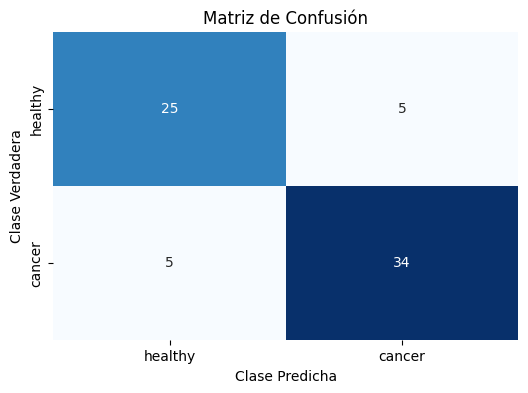

Métricas guardadas en 'model_evaluation_metrics.csv'
Accuracy: 0.8551, Balanced Accuracy: 0.8526, MCC: 0.7051, F1 Score: 0.8718
Matriz de Confusión:
[[25  5]
 [ 5 34]]


In [261]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, f1_score

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

class_names = ['healthy', 'cancer']

# Mostrar la matriz de confusión con nombres de clases
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()
# Guardar las métricas en un archivo CSV
metrics = {
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_acc,
    'MCC': mcc,
    'F1 Score': f1,
    'Confusion Matrix': conf_matrix.tolist()  # Guardar la matriz de confusión como lista para almacenamiento
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('model_evaluation_metrics.csv', index=False)

print(f"Métricas guardadas en 'model_evaluation_metrics.csv'")
print(f"Accuracy: {accuracy:.4f}, Balanced Accuracy: {balanced_acc:.4f}, MCC: {mcc:.4f}, F1 Score: {f1:.4f}")
print(f"Matriz de Confusión:\n{conf_matrix}")

# Encontrar mejores Hiperparámetros

In [ ]:
for param_index, params in enumerate(param_combinations):
        # Verificar si ya existe un resultado para esta combinación de hiperparámetros
        if any(result['params'] == params for result in results):
            print(f"SALTANDO combinación de hiperparámetros {param_index + 1} porque ya fue evaluada.")
            continue  # Saltar combinaciones ya evaluadas

        print(f"\nEvaluando combinación de hiperparámetros {param_index + 1}/{len(param_combinations)}: {params}")
        fold_accuracies = []
        fold_predictions = []

        # Obtener el número de pliegues a entrenar para esta combinación
        for fold in range(1, n_splits + 1):
            print(f"\nEvaluando el pliegue {fold}/{n_splits}")

            # Cargar los índices de entrenamiento y prueba
            train_indices = train_indices_list[fold - 1]
            test_indices = test_indices_list[fold - 1]

            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            # Convertir los datos a DataFrames
            X_train_df = pd.DataFrame(X_train)
            X_test_df = pd.DataFrame(X_test)

            # Selección de características con MI y RFE
            MI = mutual_info_classif(X_train_df, y_train)
            n_features_mi = min(5000, X_train_df.shape[1])  # Asegurar que no excede el número de características
            selected_scores_indices = np.argsort(MI)[::-1][:n_features_mi]

            X_train_mi = X_train_df.iloc[:, selected_scores_indices]
            X_test_mi = X_test_df.iloc[:, selected_scores_indices]

            estimator = LogisticRegression(max_iter=700, solver='liblinear')
            n_features_rfe = 60  # Ajustar si es necesario
            rfe = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
            rfe.fit(X_train_mi, y_train)

            X_train_final = rfe.transform(X_train_mi)
            X_test_final = rfe.transform(X_test_mi)

            # Escalado con MinMaxScaler
            scaler = MinMaxScaler()
            X_train_final = scaler.fit_transform(X_train_final)
            X_test_final = scaler.transform(X_test_final)

            X_train_final = X_train_final.astype('float32')
            X_test_final = X_test_final.astype('float32')

            # Ajustar las dimensiones para Conv1D
            genes_len = X_train_final.shape[1]
            input_shape = (genes_len, 1)
            X_train_final = X_train_final.reshape(X_train_final.shape[0], genes_len, 1)
            X_test_final = X_test_final.reshape(X_test_final.shape[0], genes_len, 1)

            # Definir y compilar el modelo
            model = getGeneXNetModel(input_shape, params)
            optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

            # Definir callbacks
            checkpoint_dir = f'{checkpoint_root_dir}/hyperparam_{param_index+1}/fold_{fold}'
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_filepath = os.path.join(checkpoint_dir, 'checkpoint_epoch_{epoch:02d}.keras')
            latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

            model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,  # Guardar el modelo completo
                monitor='val_accuracy',
                mode='max',
                save_best_only=False,  # Guardar en cada época
                verbose=1,
                save_freq='epoch'
            )

            early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

            initial_epoch = 0
            # Si existe un checkpoint previo, cargarlo y continuar entrenando
            if latest_checkpoint:
                print(f'Cargando el checkpoint existente: {latest_checkpoint}')
                model.load_weights(latest_checkpoint)
                # Extraer el número de época desde el nombre del archivo
                initial_epoch = int(latest_checkpoint.split('_epoch_')[1].split('.h5')[0])
                print(f'Continuando desde la época {initial_epoch}')
            else:
                print('Entrenando desde cero')

            # Entrenar el modelo
            model.fit(X_train_final, y_train, validation_data=(X_test_final, y_test),
                      initial_epoch=initial_epoch,
                      epochs=params['n_iter'], batch_size=params['batch_size'],
                      callbacks=[early_stop, model_checkpoint_callback], verbose=1)

            # Evaluar el modelo en el conjunto de validación
            val_acc = evaluate_model(model, X_test_final, y_test)
            fold_accuracies.append(val_acc)
            print(f"Precisión en validación del pliegue {fold}: {val_acc:.4f}")

            # Obtener predicciones finales en el conjunto de validación
            predictions, targets = get_predictions(model, X_test_final, y_test)
            fold_predictions.append((predictions, targets))

        # Calcular la precisión promedio sobre los pliegues
        if fold_accuracies:
            avg_accuracy = np.mean(fold_accuracies)
            print(f"Precisión promedio para la combinación {param_index + 1}: {avg_accuracy:.4f}")

            # Almacenar los resultados
            results.append({
                'params': params,
                'accuracy': avg_accuracy
            })

            # Almacenar las predicciones
            predictions_per_fold.append({
                'params': params,
                'predictions': fold_predictions
            })

            # Guardar los resultados actuales en Google Drive
            results_filepath = os.path.join(checkpoint_root_dir, 'checkpoint_results.pkl')
            save_results(results, predictions_per_fold, results_filepath)
        else:
            print(f"No se pudo calcular la precisión promedio para la combinación {param_index + 1} debido a la falta de datos.")